In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seed = 42 #424
np.random.seed(seed)
torch.manual_seed(seed)
#NOTE! This only works for non cudnn. gpu needs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from bayes_opt import BayesianOptimization



from helpers import showcase_code
from measures import compute_error

import itertools

In [3]:
showcase = True
toy = True

# parameter search

1. Bayesian optimization
2. to ensure comparability, we only optimize the simple model that is the base for all the ensembles
3. Optimize once for toy and once for kaggle dataset
4. parameters to optimize:
5. function to be optimized: "an objective function ceases to be a good measuerement of success when it's used as optimization target" or something like that. So we're happy to optimize for error while we're actually interested in things like cobeau and nlpd!






In [4]:

from nn_models.base_model import SimpleModel
showcase_code('nn_models/base_model.py','SimpleModel',showcase)


## toy model optimisation


In [5]:
from data_loaders import get_X_y, generate_y
#showcase_code('data_loaders.py')


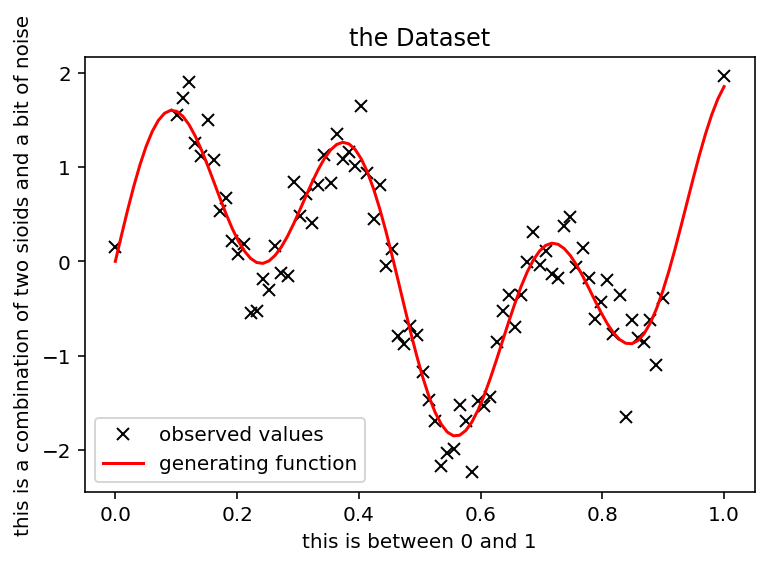

In [6]:
X_train, X_test, y_train, y_test, N, output_dims  = get_X_y(toy,seed=seed)

In [6]:
X_train.shape

(887, 37)

In [7]:
y_train.shape

(887, 1)

In [8]:
def black_box_function(model_provided, decay, num_epochs=300):
    model = SimpleModel(toy,X_train.shape[1], p=0.0, model_provided=model_provided, decay=decay)
    
    losses = []
    for i in range(num_epochs):
        losses.append(model.fit_model(X_train,y_train))
        
    y_pred = model(X_test).data.numpy()
    
    #plt.plot(X_test,y_test,'x')
    #plt.plot(X_test,y_pred,'x')
    #plt.plot(losses)
    #plt.show()
    
    return compute_error(y_test,y_pred)



In [9]:
%%time
#black_box_function(torch.nn.ReLU,0.001)

Wall time: 0 ns


In [10]:
%%time
#black_box_function(torch.nn.LeakyReLU,0.001)

Wall time: 0 ns


In [11]:
non_linearities = [torch.nn.LeakyReLU, torch.nn.ReLU]

# models = 

def make_models(n_dims_input, non_linearity, layer_tuples):
                
        
    layers_list = [[torch.nn.Linear(*layer_tuple), non_linearity()] for layer_tuple in layer_tuples] + [[torch.nn.Dropout(p=0),
    torch.nn.Linear(layer_tuples[-1][1],1)]]
    layers_list = list(itertools.chain.from_iterable(layers_list))

    
    return torch.nn.Sequential(
    torch.nn.Linear(n_dims_input,layer_tuples[0][0]),
    non_linearity(),
        
        
        
    *layers_list
        

    )
    
    #return layers_list

In [51]:
layer_tuple_list = [[(10,10)],
                    [(20,20),(20,10),(10,10)],
                    [(20,10),(10,10),(10,10),(10,10)],
                    [(20,50),(50,5),(5,10)],
                    [(10,10),(10,50),(50,10)],
                    [(100,100),(100,10)],
                    ]

In [52]:
#models = [make_models(X_train.shape[1],non_linearity, layers) for non_linearity in [torch.nn.LeakyReLU, torch.nn.ReLU, torch.nn.Sigmoid, torch.nn.Tanh] for layers in layer_tuple_list]


#models =  [make_models(X_train.shape[1],torch.nn.LeakyReLU, [(1,1)]), make_models(X_train.shape[1],torch.nn.LeakyReLU, [(10,10)])] + models

In [53]:
#len(models)

In [54]:
pbounds = {'layers':layer_tuple_list, 
           'decays': np.linspace(0.0005,0.005,num=1),
           'non_linearities':[torch.nn.LeakyReLU, torch.nn.ReLU, torch.nn.Sigmoid, torch.nn.Tanh]
          }
#pbounds = { 'decay': (0.0005,0.005)}
seeds = [1, 3, 42, 69, 420, 100, 101, 102, 103, 10]

In [ ]:
%%time
np.random.seed(0)
torch.manual_seed(0)

outcome_list = []


# run the optimization on small net to see if somethings wrong
seed_outcomes = []
for seed in seeds:
    decay = 0.005
    dumb_network = make_models(X_train.shape[1],torch.nn.LeakyReLU, [(1,1)])
    seed_outcomes.append(black_box_function(dumb_network,decay))



outcome_mean = np.mean(seed_outcomes)
outcome_std = np.std(seed_outcomes)
outcome_dict = {'params':{'model':dumb_network,'decay':decay},
                     'stats':{'outcome_mean':outcome_mean,'outcome_std':outcome_std}
                    }

print(f'dumb net results: {outcome_dict}')
outcome_list.append(outcome_dict)


num_models = len(pbounds['layers']) * len(pbounds['decays']) * len(pbounds['non_linearities'])
print(f'testing {num_models} models')


i = 0
#append the actual gridsearch
for layers in pbounds['layers']:
    for decays in pbounds['decays']:
        for non_linearity in pbounds['non_linearities']:
            i+=1
            print(f'model #{i} of {num_models}')
            seed_outcomes = []
            for seed in seeds:
                
                
                np.random.seed(seed)
                torch.manual_seed(seed) 
                
                #make_models(X_train.shape[1],torch.nn.LeakyReLU, [(1,1)])
                model = make_models(X_train.shape[1],non_linearity,layers)
                
                seed_outcomes.append(black_box_function(model,decay))
                        
            outcome_mean = np.mean(seed_outcomes)
            outcome_std = np.std(seed_outcomes)
            outcome_dict = {'params':{'model':model,'decay':decay},
                                 'stats':{'outcome_mean':outcome_mean,'outcome_std':outcome_std}
                                }
            outcome_list.append(outcome_dict)
            #print(outcome_dict)

            print(f'{np.mean(seed_outcomes), np.std(seed_outcomes)}')


dumb net results: {'params': {'model': Sequential(
  (0): Linear(in_features=37, out_features=1, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Dropout(p=0, inplace=False)
  (5): Linear(in_features=1, out_features=1, bias=True)
), 'decay': 0.005}, 'stats': {'outcome_mean': 0.701562687138013, 'outcome_std': 0.21123404575625512}}


In [ ]:
model

In [ ]:
non_linearity

In [ ]:
# %%time

# outcome_list = []
# for seed in seeds:
#     np.random.seed(seed)
#     torch.manual_seed(seed) 
    
#     models =  [make_models(X_train.shape[1],torch.nn.LeakyReLU, [(1,1)]), make_models(X_train.shape[1],torch.nn.LeakyReLU, [(10,10)])] + models
    
#     for model in pbounds['model_provided']:
#         print(model)
#         seed_outcomes = []

#         seed_outcomes.append(black_box_function(model,decay))

#         print(seed_outcomes)


#         outcome_mean = np.mean(seed_outcomes)
#         outcome_std = np.std(seed_outcomes)
#         outcome_dict = {'params':{'model':model,'decay':decay},
#                              'stats':{'outcome_mean':outcome_mean,'outcome_std':outcome_std}
#                             }
#         outcome_list.append(outcome_dict)
#         #print(outcome_dict)

#         print(f'{np.mean(seed_outcomes), np.std(seed_outcomes)}')


In [ ]:
stats = [x['stats'] for x in outcome_list] 

In [ ]:
means = [ x['outcome_mean'] for x in stats]
stds = [ x['outcome_std'] for x in stats]

In [ ]:
plt.bar(list(range(len(means))),means,yerr=stds)

In [ ]:
index = np.argmin(means)

In [ ]:
params = [x['params'] for x in outcome_list]

In [ ]:
means[index]


In [ ]:
stds[index]

In [ ]:
params[index]

In [ ]:
np.mean(means)